## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preproc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2
from keras.layers import Dropout
from keras.layers import BatchNormalization

# 建立神經網路

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], lreg = l1, l_ratio = 1e-3, drp_ratio = 0):
    
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=lreg(l_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=lreg(l_ratio))(x)
            x = Dropout(drp_ratio)(x)
            
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    model.name = 'model01'
    return model

def build_mlp_batchnormalization(input_shape, output_units=10, num_neurons=[512, 256, 128], lreg = l1, l_ratio = 1e-3,drp_ratio = 0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=lreg(l_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=lreg(l_ratio))(x)
            x = Dropout(drp_ratio)(x)
            
    x = BatchNormalization()(x)    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    model.name = 'model02'

    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
regulizer = [l1, l2]
Dropout_EXP = [0,0.3]

In [7]:
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
def batch_test(model, name):
    results = {}
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "%s-%s" % (model.name, name)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}       
    return results

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_result(results):
    color_bar = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
    plt.title("Loss")
    plt.ylim([0, 5])
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.title("Accuracy")
    plt.legend()
    plt.show()

In [9]:
model01_l1 = build_mlp(input_shape=x_train.shape[1:], lreg = l1)
model01_l1_drop = build_mlp(input_shape=x_train.shape[1:], lreg = l1,drp_ratio = 0.3)
model01_l2 = build_mlp(input_shape=x_train.shape[1:], lreg = l2)
model01_l2_drop = build_mlp(input_shape=x_train.shape[1:], lreg = l2,drp_ratio = 0.3)

In [10]:
model02_l1 = build_mlp_batchnormalization(input_shape=x_train.shape[1:], lreg = l1)
model02_l1_drop = build_mlp_batchnormalization(input_shape=x_train.shape[1:], lreg = l1,drp_ratio = 0.3)
model02_l2 = build_mlp_batchnormalization(input_shape=x_train.shape[1:], lreg = l2)
model02_l2_drop = build_mlp_batchnormalization(input_shape=x_train.shape[1:], lreg = l2,drp_ratio = 0.3)

In [11]:
results_model01_l1 = batch_test(model01_l1, 'l1')
results_model01_l1_drop = batch_test(model01_l1_drop, 'l1_drop')
results_model01_l2 = batch_test(model01_l2, 'l2')
results_model01_l2_drop = batch_test(model01_l2_drop, 'l2_droop')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

Epoch 50/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.8601 - acc: 0.4031 - val_loss: 1.8565 - val_acc: 0.4038
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
____

Epoch 49/50
50000/50000 [==============================] - 3s 61us/step - loss: 2.1013 - acc: 0.3068 - val_loss: 2.0367 - val_acc: 0.3374
Epoch 50/50
50000/50000 [==============================] - 3s 61us/step - loss: 2.0984 - acc: 0.3026 - val_loss: 2.0479 - val_acc: 0.3396
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0        

Epoch 48/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.7424 - acc: 0.6548 - val_loss: 2.1225 - val_acc: 0.5363
Epoch 49/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.7260 - acc: 0.6599 - val_loss: 2.1414 - val_acc: 0.5228
Epoch 50/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.7140 - acc: 0.6593 - val_loss: 2.0856 - val_acc: 0.5404
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131

Epoch 47/50
50000/50000 [==============================] - 3s 61us/step - loss: 2.0823 - acc: 0.5144 - val_loss: 2.0591 - val_acc: 0.5229
Epoch 48/50
50000/50000 [==============================] - 3s 60us/step - loss: 2.0660 - acc: 0.5152 - val_loss: 2.0406 - val_acc: 0.5214
Epoch 49/50
50000/50000 [==============================] - 3s 60us/step - loss: 2.0560 - acc: 0.5177 - val_loss: 2.0517 - val_acc: 0.5162
Epoch 50/50
50000/50000 [==============================] - 3s 60us/step - loss: 2.0441 - acc: 0.5187 - val_loss: 2.0253 - val_acc: 0.5221


In [12]:
results_model02_l1 = batch_test(model02_l1, 'l1')
results_model02_l1_drop = batch_test(model02_l1_drop, 'l1_drop')
results_model02_l2 = batch_test(model02_l2, 'l2')
results_model02_l2_drop = batch_test(model02_l2_drop, 'l2_droop')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
__________

Epoch 49/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.6496 - acc: 0.5064 - val_loss: 1.8429 - val_acc: 0.4447
Epoch 50/50
50000/50000 [==============================] - 3s 69us/step - loss: 1.6481 - acc: 0.5063 - val_loss: 1.7665 - val_acc: 0.4689
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0        

Epoch 47/50
50000/50000 [==============================] - 3s 66us/step - loss: 1.9812 - acc: 0.3759 - val_loss: 1.8947 - val_acc: 0.4129
Epoch 48/50
50000/50000 [==============================] - 3s 66us/step - loss: 1.9845 - acc: 0.3765 - val_loss: 1.8747 - val_acc: 0.4150
Epoch 49/50
50000/50000 [==============================] - 3s 67us/step - loss: 1.9881 - acc: 0.3711 - val_loss: 1.9773 - val_acc: 0.3856
Epoch 50/50
50000/50000 [==============================] - 3s 66us/step - loss: 1.9884 - acc: 0.3762 - val_loss: 1.8877 - val_acc: 0.4228
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)            

Epoch 45/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.3951 - acc: 0.7805 - val_loss: 2.4783 - val_acc: 0.5038
Epoch 46/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.3810 - acc: 0.7833 - val_loss: 2.4574 - val_acc: 0.5045
Epoch 47/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.3579 - acc: 0.7887 - val_loss: 2.5550 - val_acc: 0.4931
Epoch 48/50
50000/50000 [==============================] - 3s 68us/step - loss: 1.3317 - acc: 0.7945 - val_loss: 2.4413 - val_acc: 0.5204
Epoch 49/50
50000/50000 [==============================] - 3s 67us/step - loss: 1.3092 - acc: 0.7994 - val_loss: 2.4773 - val_acc: 0.5029
Epoch 50/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.3013 - acc: 0.8001 - val_loss: 2.5727 - val_acc: 0.4844
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 3072

Epoch 43/50
50000/50000 [==============================] - 3s 66us/step - loss: 2.1425 - acc: 0.4962 - val_loss: 2.1052 - val_acc: 0.5048
Epoch 44/50
50000/50000 [==============================] - 3s 65us/step - loss: 2.1292 - acc: 0.4993 - val_loss: 2.1146 - val_acc: 0.5039
Epoch 45/50
50000/50000 [==============================] - 3s 66us/step - loss: 2.1182 - acc: 0.4982 - val_loss: 2.0750 - val_acc: 0.5117
Epoch 46/50
50000/50000 [==============================] - 3s 66us/step - loss: 2.0934 - acc: 0.5039 - val_loss: 2.0656 - val_acc: 0.5122
Epoch 47/50
50000/50000 [==============================] - 3s 66us/step - loss: 2.0791 - acc: 0.5057 - val_loss: 2.0396 - val_acc: 0.5214
Epoch 48/50
50000/50000 [==============================] - 3s 66us/step - loss: 2.0627 - acc: 0.5077 - val_loss: 2.0549 - val_acc: 0.5159
Epoch 49/50
50000/50000 [==============================] - 3s 66us/step - loss: 2.0596 - acc: 0.5061 - val_loss: 2.0316 - val_acc: 0.5102
Epoch 50/50
50000/50000 [=========

In [14]:
results_all = dict(list(results_model01_l1.items()) +
                   list(results_model01_l1_drop.items())+
                   list(results_model01_l2.items())+
                   list(results_model01_l2_drop.items())+
                   list(results_model02_l1.items())+
                   list(results_model02_l1_drop.items())+
                   list(results_model02_l2.items())+
                   list(results_model02_l2_drop.items()))

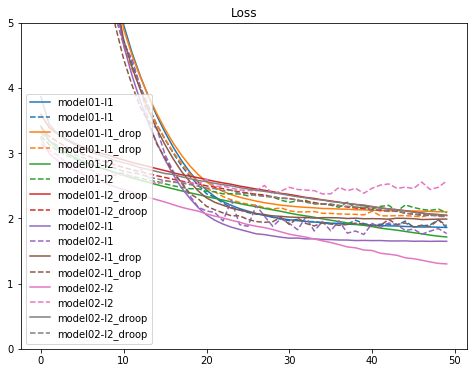

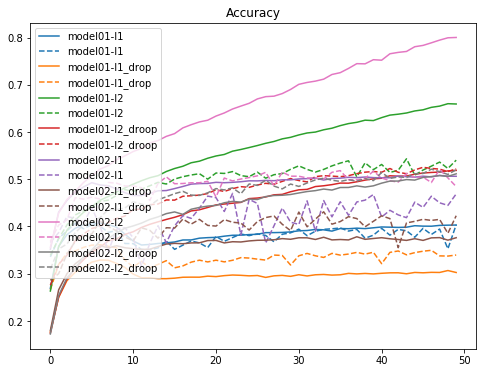

In [15]:
plot_result(results_all)